In [1]:
# This is the import cell
import sys
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib.ticker as ticker
from collections import OrderedDict
from scipy import stats
from PIL import Image
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
first = True
pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", 10)

# Here are my rc parameters for matplotlib
fsize = 10
mpl.rc('font', serif='Helvetica Neue') 
mpl.rcParams.update({'font.size': fsize})
mpl.rcParams['figure.figsize'] = 3.2, 2.8
mpl.rcParams['figure.dpi'] = 2000
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['axes.linewidth'] = 1.5
# Set x tick params
mpl.rcParams['xtick.major.size'] = 4.5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['xtick.minor.size'] = 3.
mpl.rcParams['xtick.minor.width'] = 1.25
# Set y tick params
mpl.rcParams['ytick.major.size'] = 4.5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['ytick.minor.size'] = 3.
mpl.rcParams['ytick.minor.width'] = 1.25
# Load LaTeX and amsmath
# mpl.rc('text', usetex=True)
# mpl.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

In [2]:
# Functions
def ljForce(r, eps, sigma=1.):
    div = (sigma/r)
    dU = (24. * eps / r) * ((2*(div**12)) - (div)**6)
    return dU
    
def avgCollisionForce(pe, power=1.):
    '''Computed from the integral of possible angles'''
    magnitude = np.sqrt(28.)
    return (magnitude * (pe)) / (np.pi)
    
def conForRClust(pe, eps):
    out = []
    r = 1.112
    skip = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001]
    for j in skip:
        while ljForce(r, eps) < avgCollisionForce(pe):
            r -= j
        r += j
    out = r
    return out
    
def latToPhi(latIn):
    '''Read in lattice spacing, output phi'''
    phiCP = np.pi / (2. * np.sqrt(3.))
    return phiCP / (latIn**2)
    
def compPhiG(pe, a, kap=4.05, sig=1.):
    num = 3. * (np.pi**2) * kap * sig
    den = 4. * pe * a
    return num / den
    
def clustFrac(phi, phiG, a, sig=1.):
    phiL = latToPhi(a)
    ApL = np.pi * (sig**2) / 4.
    Ap = np.pi * (sig**2) / 4.
    num = (phiL*phiG) - (phiL*phi)
    den = ((ApL/Ap)*phi*phiG) - (phi*phiL)
    ans = num / den
    return ans
    
# Lennard-Jones pressure
def ljPress(r, eps, sigma=1.):
    div = (sigma/r)
    dU = (24. * eps / r) * ((2.*(div**12.)) - (div)**6.)
    # This is just pressure divided by the area of a particle
    return (12. * dU / (np.pi * r))

def getLBox(N, phi):
    return np.sqrt(N * np.pi * 0.25 / phi)

# Define a function that takes: N, epsilon, phi, Pe. Outputs: surface tension
def getST(N, eps, phi, pe):
    phiCP = np.pi / (2. * np.sqrt(3.))
    lat = conForRClust(pe, eps)
    ljP = ljPress(lat, eps) / (10.**4.)
    phiG = compPhiG(pe, lat)
    cf = clustFrac(phi, phiG, lat)
    if cf < 0. or cf > 1.:
        cf = 0.
    Nl = cf * N
    Al = Nl * (np.pi * (lat**2) * 0.25)
    Rl = np.sqrt(Al / np.pi)
    gamma = ljP * Rl
    return gamma

In [3]:
# Range of epsilon to plot
epsRange = [0.0001, 1.]
# Activity range to plot
peRange = np.arange(35., 1000., 1.)
# Are fractions to plot
phiRange = [0.45, 0.65]
# System size to plot
NRange = [100000, 1000000]
NLines = ['-', '--']

# Constant values
constEps = epsRange[1]
constPhi = phiRange[1]
constN = NRange[0]

In [4]:
# varEps = []
# for i in range(0, len(epsRange)):
#     varEps.append([])
#     for j in range(0, len(peRange)):
#         varEps[i].append(getST(constN, epsRange[i], constPhi, peRange[j]))
        
# plt.plot(peRange, varEps[0], label=epsRange[0])
# plt.plot(peRange, varEps[1], label=epsRange[1])
# plt.legend()
# plt.show()

# varPhi = []
# for i in range(0, len(phiRange)):
#     varPhi.append([])
#     for j in range(0, len(peRange)):
#         varPhi[i].append(getST(constN, constEps, phiRange[i], peRange[j]))
        
# plt.plot(peRange, varPhi[0], label=phiRange[0])
# plt.plot(peRange, varPhi[1], label=phiRange[1])
# plt.legend()
# plt.show()

# varN = []
# for i in range(0, len(NRange)):
#     varN.append([])
#     for j in range(0, len(peRange)):
#         varN[i].append(getST(NRange[i], constEps, constPhi, peRange[j]))
        
# plt.plot(peRange, varN[0], label=phiRange[0])
# plt.plot(peRange, varN[1], label=phiRange[1])
# plt.legend()
# plt.show()

In [5]:
# Instantiate lists
lat = []
pLJ = []
cfs = []
peCrit = []
Rls = []
phiCP = np.pi / (2. * np.sqrt(3.))
norm = 10.**4.
norm = 1.

# Loop through to store all computations
for nn in range(0, len(NRange)):
    lat.append([])
    pLJ.append([])
    cfs.append([])
    peCrit.append([])
    Rls.append([])
    for i in range(0, len(epsRange)):
        lat[nn].append([])
        pLJ[nn].append([])
        cfs[nn].append([])
        peCrit[nn].append([])
        Rls[nn].append([])
        for j in range(0, len(phiRange)):
            lat[nn][i].append([])
            pLJ[nn][i].append([])
            cfs[nn][i].append([])
            peCrit[nn][i].append([])
            Rls[nn][i].append([])
            for k in range(0, len(peRange)):
                # Compute lattice spacing
                lat[nn][i][j].append(conForRClust(peRange[k], epsRange[i]))
                curPLJ = ljPress(lat[nn][i][j][-1], epsRange[i])
                pLJ[nn][i][j].append(curPLJ/(norm))

                # Compute cluster fraction
                phiG = compPhiG(peRange[k], lat[nn][i][j][-1])
                cf = clustFrac(phiRange[j], phiG, lat[nn][i][j][-1])
                if cf < 0. or cf > 1.:
                    cf = 0.
                cfs[nn][i][j].append(cf)

                # Get the critical activity
                if k > 0:
                    if cfs[nn][i][j][-2] == 0. and cfs[nn][i][j][-1] > 0.:
                        peCrit[nn][i][j].append(peRange[k])
            
                # Get the radius (for some N)
                Nl = cfs[nn][i][j][-1] * NRange[nn]
                Al = Nl * (np.pi * (lat[nn][i][j][-1]**2) * 0.25)
                Rl = np.sqrt(Al / np.pi)
                Rls[nn][i][j].append(Rl)


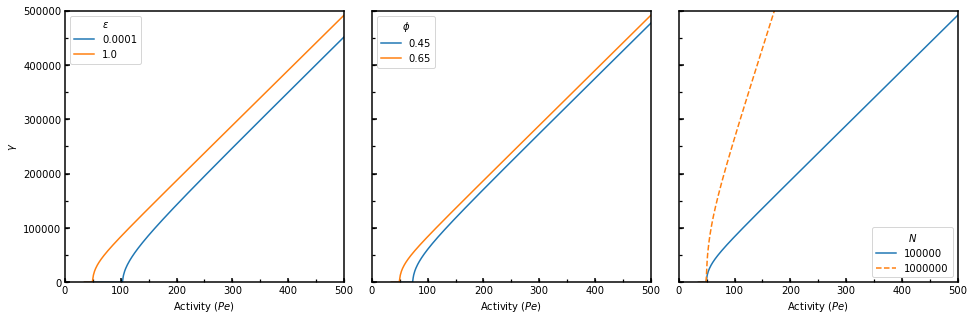

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5), sharey=True)

# Indices are: lat[n][eps][phi]
cn = 0
ce = 1
cp = 1

for i in range(0, len(epsRange)):
    st = [a * b for a, b in zip(pLJ[cn][i][cp], Rls[cn][i][cp])]
    ax[0].plot(peRange, st, label=epsRange[i])
    
for i in range(0, len(phiRange)):
    st = [a * b for a, b in zip(pLJ[cn][ce][i], Rls[cn][ce][i])]
    ax[1].plot(peRange, st, label=phiRange[i])
    
for i in range(0, len(NRange)):
    st = [a * b for a, b in zip(pLJ[i][ce][cp], Rls[i][ce][cp])]
    ax[2].plot(peRange, st, label=NRange[i], ls=NLines[i])
    
ax[0].legend(title=r'$\epsilon$')
ax[1].legend(title=r'$\phi$')
ax[2].legend(title=r'$N$')
    
ax[0].set_ylabel(r'$\gamma$')
ax[0].set_xlim(0, 500)
ax[1].set_xlim(0, 500)
ax[2].set_xlim(0, 500)
ax[0].set_ylim(0, 500000)
ax[1].set_ylim(0, 500000)
ax[2].set_ylim(0, 500000)

# Set ticks
for i in range(0, len(ax)):
    ax[i].set_xlabel(r'Activity $(Pe)$')
    
    loc = ticker.MultipleLocator(base=100)
    ax[i].xaxis.set_major_locator(loc)
    loc = ticker.MultipleLocator(base=50)
    ax[i].xaxis.set_minor_locator(loc)

    loc = ticker.MultipleLocator(base=100000)
    ax[i].yaxis.set_major_locator(loc)
    loc = ticker.MultipleLocator(base=50000)
    ax[i].yaxis.set_minor_locator(loc)

plt.subplots_adjust(wspace=0.1)
plt.savefig('st_vs_pe.pdf', bbox_inches='tight', pad_inches=0.02, dpi=1000)
plt.show()

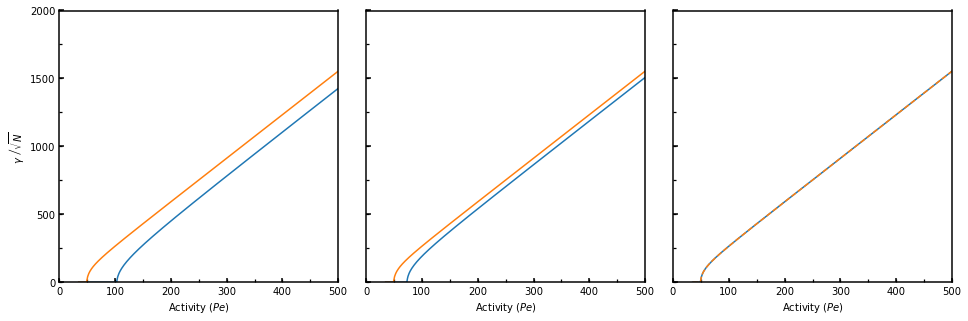

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5), sharey=True)

# Indices are: lat[n][eps][phi]
cn = 0
ce = 1
cp = 1

for i in range(0, len(epsRange)):
    ll = getLBox(NRange[cn], phiRange[cp])
    ll = np.sqrt(NRange[cn])
    st = [ (a * b) / ll for a, b in zip(pLJ[cn][i][cp], Rls[cn][i][cp])]
    ax[0].plot(peRange, st, label=epsRange[i])
    
for i in range(0, len(phiRange)):
    ll = getLBox(NRange[cn], phiRange[i])
    ll = np.sqrt(NRange[cn])
    st = [ (a * b) / ll for a, b in zip(pLJ[cn][ce][i], Rls[cn][ce][i])]
    ax[1].plot(peRange, st, label=phiRange[i])
    
for i in range(0, len(NRange)):
    ll = getLBox(NRange[i], phiRange[cp])
    ll = np.sqrt(NRange[i])
    st = [ (a * b) / ll for a, b in zip(pLJ[i][ce][cp], Rls[i][ce][cp])]
    ax[2].plot(peRange, st, label=NRange[i], ls=NLines[i])
    
# ax[0].legend(title=r'$\epsilon$')
# ax[1].legend(title=r'$\phi$')
# ax[2].legend(title=r'$N$')
    
ax[0].set_ylabel(r'$\gamma\ \left/\sqrt{N}\right.$')
ax[0].set_ylim(0, 2000)
ax[1].set_ylim(0, 2000)
ax[2].set_ylim(0, 2000)
ax[0].set_xlim(0, 500)
ax[1].set_xlim(0, 500)
ax[2].set_xlim(0, 500)

# Set ticks
for i in range(0, len(ax)):
    ax[i].set_xlabel(r'Activity $(Pe)$')
    
    loc = ticker.MultipleLocator(base=100)
    ax[i].xaxis.set_major_locator(loc)
    loc = ticker.MultipleLocator(base=50)
    ax[i].xaxis.set_minor_locator(loc)

    loc = ticker.MultipleLocator(base=500)
    ax[i].yaxis.set_major_locator(loc)
    loc = ticker.MultipleLocator(base=250)
    ax[i].yaxis.set_minor_locator(loc)

plt.subplots_adjust(wspace=0.1)
plt.savefig('st_div_n_vs_pe.pdf', bbox_inches='tight', pad_inches=0.02, dpi=1000)
plt.show()

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in divide
  if sys.path[0] == '':
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in divide
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in divide


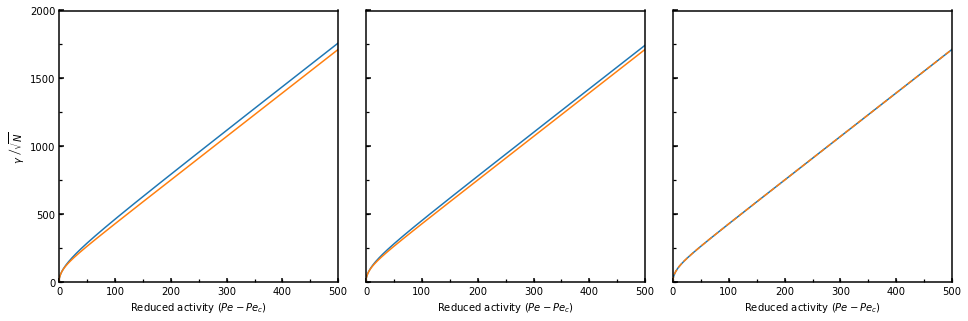

In [8]:
# Final plot with reduced activity
fig, ax = plt.subplots(1, 3, figsize=(16, 5), sharey=True)

# Indices are: lat[n][eps][phi]
cn = 0
ce = 1
cp = 1

for i in range(0, len(epsRange)):
    ll = np.sqrt(NRange[cn])
    st = [ (a * b) / ll for a, b in zip(pLJ[cn][i][cp], Rls[cn][i][cp])]
    divPe = [ a / (b - peCrit[cn][i][cp]) for a, b in zip(st, peRange)]
    ax[0].plot(peRange - peCrit[cn][i][cp], st, label=epsRange[i])
    
for i in range(0, len(phiRange)):
    ll = np.sqrt(NRange[cn])
    st = [ (a * b) / ll for a, b in zip(pLJ[cn][ce][i], Rls[cn][ce][i])]
    divPe = [ a / (b - peCrit[cn][ce][i]) for a, b in zip(st, peRange)]
    ax[1].plot(peRange - peCrit[cn][ce][i], st, label=phiRange[i])
    
for i in range(0, len(NRange)):
    ll = np.sqrt(NRange[i])
    st = [ (a * b) / ll for a, b in zip(pLJ[i][ce][cp], Rls[i][ce][cp])]
    divPe = [ a / (b - peCrit[i][ce][cp]) for a, b in zip(st, peRange)]
    ax[2].plot(peRange - peCrit[i][ce][cp], st, label=NRange[i], ls=NLines[i])
    
# ax[0].legend(title=r'$\epsilon$')
# ax[1].legend(title=r'$\phi$')
# ax[2].legend(title=r'$N$')
    
ax[0].set_ylabel(r'$\gamma\ \left/\sqrt{N}\right.$')
ax[0].set_ylim(0, 2000)
ax[1].set_ylim(0, 2000)
ax[2].set_ylim(0, 2000)
ax[0].set_xlim(0, 500)
ax[1].set_xlim(0, 500)
ax[2].set_xlim(0, 500)

# Set ticks
for i in range(0, len(ax)):
    ax[i].set_xlabel(r'Reduced activity $(Pe - Pe_{c})$')
    
    loc = ticker.MultipleLocator(base=100)
    ax[i].xaxis.set_major_locator(loc)
    loc = ticker.MultipleLocator(base=50)
    ax[i].xaxis.set_minor_locator(loc)

    loc = ticker.MultipleLocator(base=500)
    ax[i].yaxis.set_major_locator(loc)
    loc = ticker.MultipleLocator(base=250)
    ax[i].yaxis.set_minor_locator(loc)

plt.subplots_adjust(wspace=0.1)
plt.savefig('st_div_n_vs_per.pdf', bbox_inches='tight', pad_inches=0.02, dpi=1000)
plt.show()

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in divide
  if sys.path[0] == '':
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in divide
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in divide


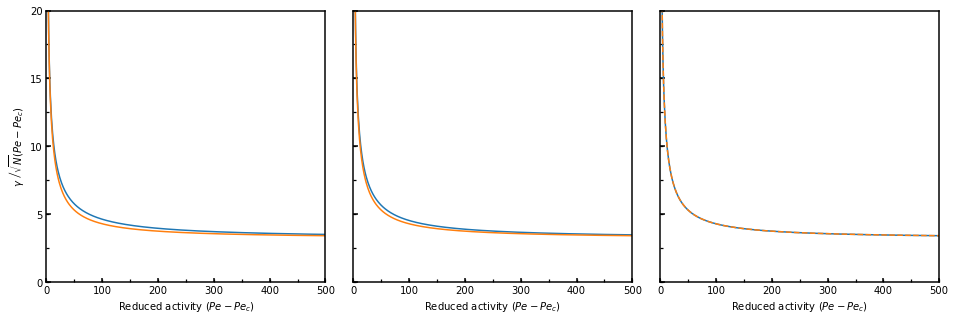

In [9]:
# Final plot with reduced activity
fig, ax = plt.subplots(1, 3, figsize=(16, 5), sharey=True)

# Indices are: lat[n][eps][phi]
cn = 0
ce = 1
cp = 1

for i in range(0, len(epsRange)):
    ll = np.sqrt(NRange[cn])
    st = [ (a * b) / ll for a, b in zip(pLJ[cn][i][cp], Rls[cn][i][cp])]
    divPe = [ a / (b - peCrit[cn][i][cp]) for a, b in zip(st, peRange)]
    ax[0].plot(peRange - peCrit[cn][i][cp], divPe, label=epsRange[i])
    
for i in range(0, len(phiRange)):
    ll = np.sqrt(NRange[cn])
    st = [ (a * b) / ll for a, b in zip(pLJ[cn][ce][i], Rls[cn][ce][i])]
    divPe = [ a / (b - peCrit[cn][ce][i]) for a, b in zip(st, peRange)]
    ax[1].plot(peRange - peCrit[cn][ce][i], divPe, label=phiRange[i])
    
for i in range(0, len(NRange)):
    ll = np.sqrt(NRange[i])
    st = [ (a * b) / ll for a, b in zip(pLJ[i][ce][cp], Rls[i][ce][cp])]
    divPe = [ a / (b - peCrit[i][ce][cp]) for a, b in zip(st, peRange)]
    ax[2].plot(peRange - peCrit[i][ce][cp], divPe, label=NRange[i], ls=NLines[i])
    
# ax[0].legend(title=r'$\epsilon$')
# ax[1].legend(title=r'$\phi$')
# ax[2].legend(title=r'$N$')
    
ax[0].set_ylabel(r'$\gamma\ \left/\sqrt{N}\right.\left(Pe-Pe_{c}\right)$')
ax[0].set_ylim(0, 20)
ax[1].set_ylim(0, 20)
ax[2].set_ylim(0, 20)
ax[0].set_xlim(0, 500)
ax[1].set_xlim(0, 500)
ax[2].set_xlim(0, 500)

# Set ticks
for i in range(0, len(ax)):
    ax[i].set_xlabel(r'Reduced activity $(Pe - Pe_{c})$')
    
    loc = ticker.MultipleLocator(base=100)
    ax[i].xaxis.set_major_locator(loc)
    loc = ticker.MultipleLocator(base=50)
    ax[i].xaxis.set_minor_locator(loc)

    loc = ticker.MultipleLocator(base=5)
    ax[i].yaxis.set_major_locator(loc)
    loc = ticker.MultipleLocator(base=2.5)
    ax[i].yaxis.set_minor_locator(loc)

plt.subplots_adjust(wspace=0.1)
plt.savefig('st_div_nper_vs_per.pdf', bbox_inches='tight', pad_inches=0.02, dpi=1000)
plt.show()